# 3. In-depth Tutorial

This section provides a more in-depth tutorial compared to Section 2, and will discuss the intuition behind the different features of the IntPrim library.
One of the main strengths of this library is that very few parameters must be manually specified in order to perform inference, so we will also cover the utilities and quality-of-life features that enable this data-driven approach.

## Basis Spaces

### Supported basis functions

The IntPrim library natively supports three different types of basis functions:

* Gaussian radial basis functions
* Logistic sigmoid radial basis functions
* Polynomial basis functions

Section 2 introduced the Gaussian basis model when fitting to the generated synthetic handwriting data.

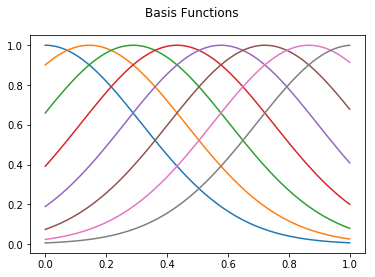

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import the library.
import intprim

# Set a seed for reproducibility
np.random.seed(213413414)

# Define the data axis names.
dof_names = np.array(["X", "Y"])

# Decompose the handwriting trajectories to a basis space with 8 uniformly distributed Gaussian functions and a variance of 0.1.
basis_model_gaussian = intprim.basis.GaussianModel(8, 0.1, dof_names)

basis_model_gaussian.plot()

The Gaussian basis space can be seen in the above plot. In this case, it consists of 8 functions uniformly distributed from 0.0 to 1.0 phase with a variance of 0.1. We can fit a sample trajectory to this basis space and plot the results.

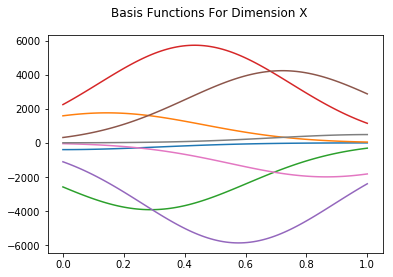

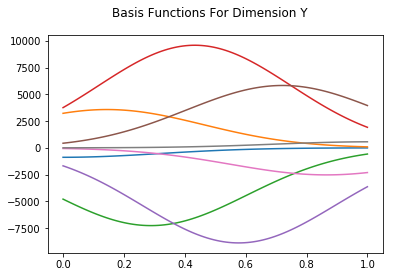

In [2]:
# Define some parameters used when generating synthetic data.
num_train_trajectories = 50
train_translation_mean = 0.0
train_translation_std = 5.0
train_noise_std = 0.01
train_length_mean = 95
train_length_std = 30

# Generate some synthetic handwriting trajectories.
training_trajectories = intprim.examples.create_2d_handwriting_data(
    num_train_trajectories,
    train_translation_mean,
    train_translation_std,
    train_noise_std,
    train_length_mean,
    train_length_std)

domain = np.linspace(0, 1, training_trajectories[0].shape[1], dtype = intprim.constants.DTYPE)
weights = basis_model_gaussian.fit_basis_functions_linear_closed_form(domain, training_trajectories[0].T).reshape(2, 8)
basis_model_gaussian.plot_weighted(weights, dof_names)

The process of fitting a basis model to a demonstration is normally handled implicitly by the `add_demonstration()` method in `BayesianInteractionPrimitive`, but we do it manually here to illustrate what is happening. The `GaussianModel` is a good all-around choice, but it's not always the most appropriate. For this reason, we also provide the `SigmoidalModel`,

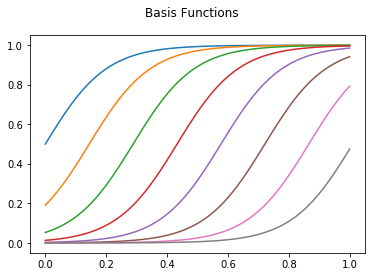

In [3]:
basis_model_sigmoidal = intprim.basis.SigmoidalModel(8, 0.1, dof_names)

basis_model_sigmoidal.plot()

as well as the `PolynomialModel`,

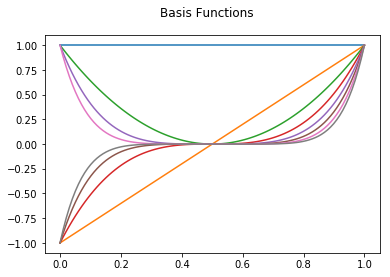

In [4]:
basis_model_polynomial = intprim.basis.PolynomialModel(8, dof_names)

basis_model_polynomial.plot()

These models all satisfy the same API and can be used interchangeably, with the exception that `PolynomialModel` does not take a `scale` parameter.

### Choosing an appropriate basis space

With all of these basis functions and parameters to choose from, how do we choose an appropriate basis space? We provide such functionality in IntPrim through the `Selection` class. This performs a grid search over a set of basis functions and parameters and chooses the one with the lowest Bayesian Information Criterion as well as Aikake Information Criterion. The grid parameters can be modified within the class depending on the use-case.

In [5]:
selection = intprim.basis.Selection(dof_names)

for trajectory in training_trajectories:
    selection.add_demonstration(trajectory)

aic, bic = selection.get_information_criteria(np.array([0, 1], dtype = np.int32))
selection.get_best_model(aic, bic)

Fitting PolynomialModel. Degree: 5. Scale: None
Fitting PolynomialModel. Degree: 7. Scale: None
Fitting PolynomialModel. Degree: 9. Scale: None
Fitting PolynomialModel. Degree: 11. Scale: None
Fitting PolynomialModel. Degree: 13. Scale: None
Fitting GaussianModel. Degree: 5. Scale: 0.01
Fitting GaussianModel. Degree: 5. Scale: 0.04
Fitting GaussianModel. Degree: 5. Scale: 0.07
Fitting GaussianModel. Degree: 5. Scale: 0.1
Fitting GaussianModel. Degree: 5. Scale: 0.13
Fitting GaussianModel. Degree: 5. Scale: 0.16
Fitting GaussianModel. Degree: 5. Scale: 0.19
Fitting GaussianModel. Degree: 7. Scale: 0.01
Fitting GaussianModel. Degree: 7. Scale: 0.04
Fitting GaussianModel. Degree: 7. Scale: 0.07
Fitting GaussianModel. Degree: 7. Scale: 0.1
Fitting GaussianModel. Degree: 7. Scale: 0.13
Fitting GaussianModel. Degree: 7. Scale: 0.16
Fitting GaussianModel. Degree: 7. Scale: 0.19
Fitting GaussianModel. Degree: 9. Scale: 0.01
Fitting GaussianModel. Degree: 9. Scale: 0.04
Fitting GaussianModel. D

(<intprim.basis.gaussian_model.GaussianModel at 0x1a195ff9d0>,
 <intprim.basis.gaussian_model.GaussianModel at 0x1a195ff9d0>)

In this case, we can see that AIC and BIC both chose the `GaussianModel` with degree 9 and variance 0.1 as the best model. This is a very reasonable selection since the synthetic handwriting data is actually generated from a `GaussianModel` with 8 functions and 0.1 variance (see `create_2d_handwriting_data` in `examples/tutorial.py`). Note that the selection is influenced by the noise in the data as well as the model noise used by Selection when calculating the log-likelihood (by default that is set to 0.05).

### Utilizing multiple basis spaces

Now that we can leverage multiple basis spaces and choose the best one, the question is what if we want to use a different basis space for each degree of freedom? In the above case, we performed selection over both degrees of freedom at once (by specifying np.array([0, 1]) as a parameter), but we could just as easily have performed it separately. In this case, it is likely that each DoF would be better approximated by a different basis space. IntPrim can accommodate this through the use of a `MixtureModel` (not to be confused with mixture models as used for density estimation). For example, let's assume that we want to use a `GaussianModel` with 8 functions and 0.1 variance for X and a `SigmoidalModel` with 8 functions and 0.1 variance for Y.

In [6]:
basis_model_gaussian = intprim.basis.GaussianModel(8, 0.1, ["X"])
basis_model_sigmoidal = intprim.basis.SigmoidalModel(8, 0.1, ["Y"])
models = [basis_model_gaussian, basis_model_sigmoidal]

basis_model_mixture = intprim.basis.MixtureModel(models)

This model can now be directly passed to filters just like a regular basis model would be. Note that the order of the models in the list matters! If we reversed them and passed `[basis_model_sigmoidal, basis_model_gaussian]` then we would effctively reverse the mapping of the degrees of freedom.

### Computing observation noise

There is one more aspect that we can use `Selection` for, and that is to calculate the observation noise from a set of training demonstrations. Functionally, we calculate the observation noise as simply the mean squared error of the regression fit of our basis spaces to the data. Intuitively, this represents the variance of the data around the regression and captures both the approximation error and the sensor noise associated with the observations.

In [7]:
observation_noise = np.diag(selection.get_model_mse(basis_model_mixture, np.array([0, 1])))
print(observation_noise)

[[  9.14497375e-05   0.00000000e+00]
 [  0.00000000e+00   1.12962836e-02]]


The array returned by `get_model_mse` is the diagonal of the covariance matrix for the noise, but since we assume that the errors are not correlated it is a trivial matter to expand this into a full covariance matrix. It is interesting to observe here the impact that the basis space selection has on the observation error. The synthetic data is generated from a `GaussianModel` with 8 functions and 0.1 variance, which produces an MSE of ~9e-5 on that same `GaussianModel` for the x-axis, which is approximately equal to `train_noise_std ** 2` as we would expect. However, for the `SigmoidalModel` on the y-axis it yields a significantly larger MSE of ~1e-2. This reinforces how important it is to select a proper basis space in order to minimize approximation errors.

### Scaling

Lastly, we will show how scaling can be used with basis models.

In [8]:
# Define a scaling group where both DoFs are scaled together.
scaling_groups_together = [
    [0, 1]
]
# Define a scaling group where the DoFs are scaled separately.
scaling_groups_separate = [
    [0],
    [1]
]

# Initialize a BIP instance.
primitive = intprim.BayesianInteractionPrimitive(basis_model_mixture, scaling_groups = scaling_groups_together)

# First compute the scaling
for trajectory in training_trajectories:
    primitive.compute_standardization(trajectory)

# Then add the demonstrations
for trajectory in training_trajectories:
    primitive.add_demonstration(trajectory)

Scaling applies a MinMax scaling such that the maximum value in the training demonstrations is scaled to 1 and the minimum value to 0. Scaling can be applied to individual DoFs or groups; it doesn't make sense to scale gyroscope and actuator measurements together, for example. This is easy to define: the scaling groups is simply a list of lists where the sub-lists specify data indices that should be scaled together as a group. No matter which grouping is used, however, the scalers must first be initialized over the entire data set before training any demonstrations! This is because the weights that are extracted when adding a demonstration are dependent on the scaling that is used, and this cannot be re-computed after the fact if the scaling changes.

*Important note*: if scaling is used it is very important to compute the observation error using the Selection class above. This is because scaling will significantly affect the magnitude of the observation error and will impact inference performance if scaling is turned on without adjusting the noise.
This can be seen by the much smaller observation error produced below.

In [9]:
selection = intprim.basis.Selection(dof_names, scaling_groups = scaling_groups_together)

for trajectory in training_trajectories:
    selection.add_demonstration(trajectory)

observation_noise = np.diag(selection.get_model_mse(basis_model_mixture, np.array([0, 1])))
print(observation_noise)

[[  1.61214806e-07   0.00000000e+00]
 [  0.00000000e+00   3.46379670e-05]]


## Export and Import

Once a primitive has been trained, it is a simple matter to export and import it such that training doesn't have to be repeated.

### Export

Exporting can be accomplished simply by calling export_data and passing a file name.

In [10]:
primitive.export_data("some_file_name.bip")

Exporting data to: some_file_name.bip


### Import

And importing is just as simple.

In [11]:
primitive.import_data("some_file_name.bip")

Importing data from: some_file_name.bip


## Filters

IntPrim supports three different spatiotemporal filters and one spatial filter. These filters affect both the accuracy and computational performance of inference. Mathematical details on how these filters function can be found in Section 4.

### Spatiotemporal filters

IntPrim supports three types of spatiotemporal nonlinear filters:
* ensemble Kalman filter as used in Ensemble Bayesian Interaction Primitives[1]
* extended Kalman filter as used in Bayesian Interaction Primitives[2]
* particle filter

All of these filters produce a probabilistic estimate of the state of the interaction, where we define the state as consisting of the phase (temporal state) and the weights corresponding to the basis model (spatial state).
The objective is to simultaneously infer both the spatial and temporal state given a sequence of observations from an interaction of unknown length.

As with any state space-based filter, we must define a transition function which describes how we predict the state will evolve at the beginning of each time step; this occurs in the aptly named prediction step.
While the basis weights in the state space are time invariant and do not have a meaningful state transition, the phase value is time varying.
We assume that the phase follows a linear constant velocity model, that is, we estimate both the phase and phase velocity and assume that the velocity remains constant between any two consecutive time steps (more details on this in Section 4).
The state transition matrix then is well-defined and does not need to be specifically provided to the filters, however, the process noise does need to be defined as it may vary from scenario to scenario depending on how quickly observations were collected and how confident we are that the constant velocity model accurately represents the interaction.
From experience, a good rule of thumb is a process noise value of 1e-8 for observation frequencies between 30-60 Hz.

In addition, before we can initialize any filter we must determine the initial values of the state.
The initial temporal state is computed from the length of the training demonstrations and for all spatiotemporal filters we model it with a Gaussian distribution, thus we need to estimate the mean and covariance parameters.

In [12]:
# Compute the phase mean and phase velocities from the demonstrations.
phase_velocity_mean, phase_velocity_var = intprim.examples.get_phase_stats(training_trajectories)
phase_mean = 0.0
phase_var = 1e-4

process_var = 1e-8

# Define the initial mean/variance of the temporal state.
initial_phase_mean = [phase_mean, phase_velocity_mean]
initial_phase_var = [phase_var, phase_velocity_var]

In the above code, we compute the initial mean and variance of both the phase and phase velocity that corresponds to a 1st order linear constant velocity system.
We assume that there is no initial correlation between the phase and the velocity, so only the diagonal of the covariance matrix is specified in `initial_phase_var`.
Note that we have assumed that the phase always begins at 0.0 with a large degree of confidence (uncertainty is 1e-4).
This does not necessarily need to be the case; for example if we're not sure whether we've observed an interaction from the beginning we could adjust the mean and increase the variance and allow the filter to attempt to correct.
Furthermore, while a 1st order system is the default model, IntPrim also supports 0th order (phase only) and 2nd order (phase, velocity, acceleration) systems:

In [13]:
# Define the initial mean/variance for a 0th order system.
initial_phase_mean = [phase_mean]
initial_phase_var = [phase_var]

# Arbitrarily choose acceleration values
phase_accel_mean = 1e-4
phase_accel_var = 1e-10

# Define the initial mean/variance for a 2nd order system.
initial_phase_mean = [phase_mean, phase_velocity_mean, phase_accel_mean]
initial_phase_var = [phase_var, phase_velocity_var, phase_accel_var]

Of course, if a 2nd order system is used in practice the acceleration values should be chosen with some care; the ones used here are just for demonstration.
Lastly, we can put everything together and initialize our filters.

##### Ensemble Bayesian Interaction Primitives (ensemble Kalman filter)

There are two ways to initialize an ensemble Kalman filter.
The first (and preferred) method is to initialize the ensemble directly from a set of training demonstrations.

In [14]:
# Initialize an ensemble Kalman filter
filter_enkf = intprim.filter.spatiotemporal.EnsembleKalmanFilter(
    basis_model = basis_model_mixture,
    initial_phase_mean = initial_phase_mean,
    initial_phase_var = initial_phase_var,
    proc_var = process_var,
    initial_ensemble = primitive.basis_weights)

Here we've directly provided the basis weights with `initial_ensemble` that will serve as the initial spatial states for the ensemble.
In this method as well as the particle filter, the temporal states of the ensemble will be sampled from a Gaussian distribution with the parameters specified in `initial_phase_mean` and `initial_phase_var`.

The second method is to sample the initial ensemble from some probability distribution that approximates the true unknown distribution:

In [15]:
import sklearn.mixture

ensemble_sampler = sklearn.mixture.GaussianMixture(n_components = 2, reg_covar = 1e-4)
ensemble_sampler.fit(primitive.basis_weights)

sampled_ensemble = ensemble_sampler.sample(num_train_trajectories)[0]

# Initialize an ensemble Kalman filter
filter_enkf = intprim.filter.spatiotemporal.EnsembleKalmanFilter(
    basis_model = basis_model_mixture,
    initial_phase_mean = initial_phase_mean,
    initial_phase_var = initial_phase_var,
    proc_var = 1e-8,
    initial_ensemble = sampled_ensemble)

In general, the first method where the demonstrations are used directly results in increased inference accuracy since it does not accumulate any density approximation errors over the prior.
However, if the number of available training demonstrations is less than the number of required ensemble members, then the second option may be employed.

##### Bayesian Interaction Primitives (extended Kalman filter)

Unlike the ensemble Kalman filter, the extended Kalman filter as used in Bayesian Interaction Primitives does not use Monte Carlo approximation and instead computes the state posterior probability distribution analytically.
As a result, the initializatino procedure differs from the ensemble Kalman filter in that we compute the sample mean and covariance of the training demonstrations and pass those, rather than the initial ensemble directly.

In [16]:
# Calculate sample mean and covariance of demonstrations
mean, cov = primitive.get_basis_weight_parameters()

# Initialize an extended Kalman filter
filter_ekf = intprim.filter.spatiotemporal.ExtendedKalmanFilter(
    basis_model = basis_model_mixture,
    initial_phase_mean = initial_phase_mean,
    initial_phase_var = initial_phase_var,
    proc_var = 1e-8,
    mean_basis_weights = mean,
    cov_basis_weights = cov)

##### Particle filter

The particle filter is another ensemble-based nonlinear filter, much like the ensemble Kalman filter, and subsequently is initialized in a very similar fashion.
The only additional parameter is the introduction of a ratio which is used as a threshold to trigger the resampling strategy.
If the number of effective samples falls below this ratio, then resampling is performed.

In [17]:
# Initialize a particle filter
filter_pf = intprim.filter.spatiotemporal.ParticleFilter(
    basis_model = basis_model_mixture,
    initial_phase_mean = initial_phase_mean,
    initial_phase_var = initial_phase_var,
    proc_var = process_var,
    initial_ensemble = primitive.basis_weights,
    num_effective_ratio = 0.5)

### Spatial filters

All of these filters produce a probabilistic estimate of the state of the interaction, where we define the state as consisting of the phase (temporal state) and the weights corresponding to the basis model (spatial state).
The objective is to simultaneously infer both the spatial and temporal state given a sequence of observations from an interaction of unknown length.

In contrast to the spatiotemporal filters, the spatial filters (of which there is currently only one) produce a probabilistic state estimate which consists of only the basis model -- the spatial state.
The temporal state is inferred separately from the filter through an explicit time alignment algorithm such as Dynamic Time Warping.

##### Probabilistic Movement Primitives (Kalman filter)

In [18]:
# Initialize a Kalman filter
filter_kf = intprim.filter.KalmanFilter(
    basis_model = basis_model_mixture,
    mean_basis_weights = mean,
    cov_basis_weights = cov,
    align_func = intprim.filter.align.dtw.fastdtw,
    iterative_alignment = False)

The only additional parameters we need to worry about in this case are `align_func` and `iterative_alignment`.
Currently, only one alignment function is included natively -- Dynamic Time Warping -- but others can easily be utilized by writing a custom function which returns the index corresponding to the currently estimated phase.
The `iterative_alignment` flag indicates whether alignment should be performed over the entire trajectory each time, meaning on every iteration it aligns from phase 0 to phase 1; or whether alignment is performed recursively from last iteration, meaning it aligns from the currently estimated phase to phase 1.
In practice, we have found using iterative alignment introduces a significant amount of accumulated error over many time steps and so we do not recommend setting this to True.

### Cyclical filtering

One option that is common to (currently only spatiotemporal) filters is the ability to perform cyclical filtering.
This is useful for performing inference with periodic or rhythmic interactions where we want the phase of the interaction to "roll over" back to 0 once it reaches 1, thus resetting the temporal progress and allowing the interaction to continue indefinitely.
To perform cyclical filtering simply set the `cyclical` flag to True; an example is shown below.

In [19]:
# Initialize an ensemble Kalman filter
filter_enkf = intprim.filter.spatiotemporal.EnsembleKalmanFilter(
    basis_model = basis_model_mixture,
    initial_phase_mean = initial_phase_mean,
    initial_phase_var = initial_phase_var,
    proc_var = process_var,
    initial_ensemble = primitive.basis_weights,
    cyclical = True)

## Inference

We will now examine some of the different ways in which we can perform inference over a sequence of observations.
The example given in Section 2 is indicative of a general method in which we want to infer the trajectory from the currently estimated phase to the end of the interaction. We re-state it here using everything we've introduced so far in this tutorial:

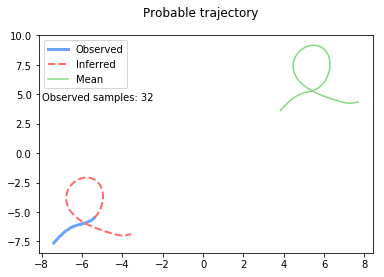

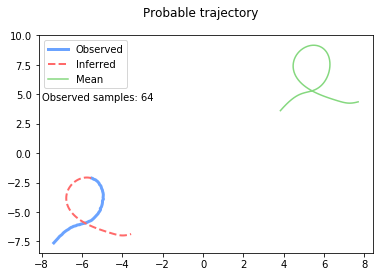

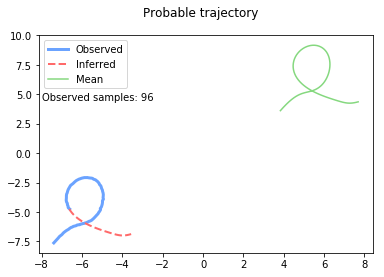

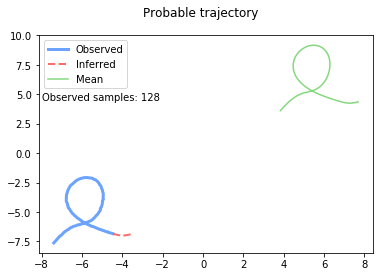

In [20]:
import copy

################ Initialize the BIP instance ################

# Define a scaling group where both DoFs are scaled together.
scaling_groups_together = [
    [0, 1]
]

# Use the model that we found during selection earlier.
basis_model_gaussian = intprim.basis.GaussianModel(9, 0.1, dof_names)

# Initialize a BIP instance.
primitive = intprim.BayesianInteractionPrimitive(basis_model_gaussian, scaling_groups = scaling_groups_together)

# First compute the scaling.
for trajectory in training_trajectories:
    primitive.compute_standardization(trajectory)

# Then add the demonstrations.
for trajectory in training_trajectories:
    primitive.add_demonstration(trajectory)

################ Determine the observation noise ################

selection = intprim.basis.Selection(dof_names, scaling_groups = scaling_groups_together)

for trajectory in training_trajectories:
    selection.add_demonstration(trajectory)

# Get the observation noise. Note that it is much smaller than train_noise_std^2 because we have scaled the values between [0, 1]. 
observation_noise = np.diag(selection.get_model_mse(basis_model_gaussian, np.array([0, 1])))

################ Create a test trajectory ################

num_test_trajectories = 1
test_translation_mean = -10.0
test_translation_std = 1e-5
test_noise_std = 0.01
test_length_mean = 145
test_length_std = 1e-5

# Create test trajectories.
test_trajectories = intprim.examples.create_2d_handwriting_data(num_test_trajectories, test_translation_mean, test_translation_std, test_noise_std, test_length_mean, test_length_std)

# Explicitly zero out the x-axis values to illustrate that they are not being used.
test_trajectory_partial = np.array(test_trajectories[0], copy = True)
test_trajectory_partial[0, :] = 0.0

# We must make sure to inflate the corresponding observation noise entry as well so we ignore the zero values.
observation_noise[0, 0] = 10000.0

# Define the active DoF to only be the y-axis.
active_dofs = np.array([1])

################ Create a filter for inference ################

# Compute the phase mean and phase velocities from the demonstrations.
phase_velocity_mean, phase_velocity_var = intprim.examples.get_phase_stats(training_trajectories)
phase_mean = 0.0
phase_var = 1e-4

process_var = 1e-8

# Define the initial mean/variance of the temporal state.
initial_phase_mean = np.array([phase_mean, phase_velocity_mean])
initial_phase_var = np.array([phase_var, phase_velocity_var])

# Initialize an ensemble Kalman filter.
filter_enkf = intprim.filter.spatiotemporal.EnsembleKalmanFilter(
    basis_model = basis_model_gaussian,
    initial_phase_mean = initial_phase_mean,
    initial_phase_var = initial_phase_var,
    proc_var = process_var,
    initial_ensemble = primitive.basis_weights)

################ Initialize the BIP instance for inference ################

# Set the filter using a deep copy that way we can re-use the filter for inference multiple times without having to re-create it from scratch.
# This is simply for convenience.
primitive.set_filter(copy.deepcopy(filter_enkf))

################ Perform inference and plot the results ################

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory()

prev_observed_index = 0
for observed_index in range(32, test_trajectory_partial.shape[1], 32):
    # Perform inference over the test trajectory in batches of 32 samples, just so we can clearly plot how the inference changes over time.
    # In practice, you can pass as many or as few observations at a time as desired.
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(
        test_trajectory_partial[:, prev_observed_index:observed_index],
        observation_noise,
        active_dofs,
        num_samples = test_trajectory_partial.shape[1] - observed_index)
    
    prev_observed_index = observed_index
    
    # Plot the results as we go.
    intprim.util.visualization.plot_partial_trajectory(inferred_trajectory, test_trajectories[0][:, :observed_index], mean_trajectory)

As we can see above, the filter does an exceptional job tracking both the spatial and temporal states, despite the large translation and increased length of the test sequence.
This system is fairly robust, so play around with the parameters used to generate the test trajectory and observe how it performs in different scenarios.
This remains true even if we significantly increase the noise of the test trajectory as shown below.

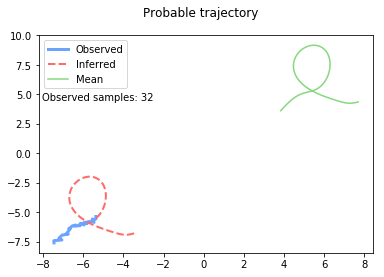

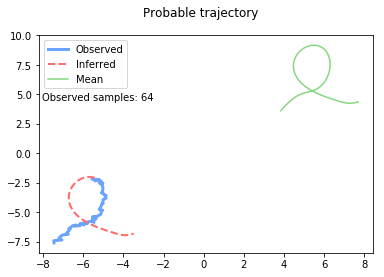

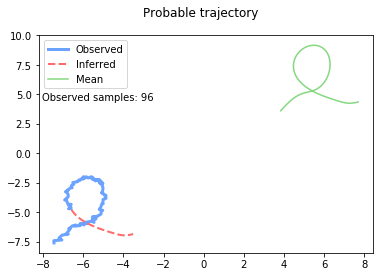

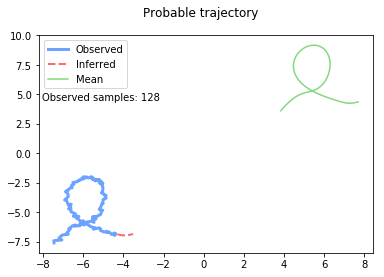

In [21]:
################ Create a test trajectory ################

num_test_trajectories = 1
test_translation_mean = -10.0
test_translation_std = 1e-5
test_noise_std = 0.08
test_length_mean = 145
test_length_std = 1e-5

# Create test trajectories.
test_trajectories = intprim.examples.create_2d_handwriting_data(num_test_trajectories, test_translation_mean, test_translation_std, test_noise_std, test_length_mean, test_length_std)

# Explicitly zero out the x-axis values to illustrate that they are not being used.
test_trajectory_partial = np.array(test_trajectories[0], copy = True)
test_trajectory_partial[0, :] = 0.0

################ Initialize the BIP instance for inference ################

# Set the filter using a deep copy that way we can re-use the filter for inference multiple times without having to re-create it from scratch.
# This is simply for convenience.
primitive.set_filter(copy.deepcopy(filter_enkf))

################ Perform inference and plot the results ################

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory()

prev_observed_index = 0
for observed_index in range(32, test_trajectory_partial.shape[1], 32):
    # Perform inference over the test trajectory in batches of 32 samples, just so we can clearly plot how the inference changes over time.
    # In practice, you can pass as many or as few observations at a time as desired.
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(
        test_trajectory_partial[:, prev_observed_index:observed_index],
        observation_noise,
        active_dofs,
        num_samples = test_trajectory_partial.shape[1] - observed_index)
    
    prev_observed_index = observed_index
    
    # Plot the results as we go.
    intprim.util.visualization.plot_partial_trajectory(inferred_trajectory, test_trajectories[0][:, :observed_index], mean_trajectory)

However, there is a limit to the amount of simultaneous generalization that can occur if the observations are especially noisy in both space and time.
This is covered in more detail in Section 4, but the intuitive explanation is that if we make an observation and are very uncertain about what is happening and when it is happening, then it is difficult to adjust the state estimate because the individual error contributions from the spatial and temporal estimates cannot be determined accurately.

### Inferred trajectory length

The length of the inferred trajectory can be adjusted through the `num_samples` parameter of `generate_probable_trajectory_recursive`.
While at first glance this may seem trivial, it has a significant impact on the smoothness of the resulting trajectory.
For example, if we set it arbitrarily low we end up with something like this.

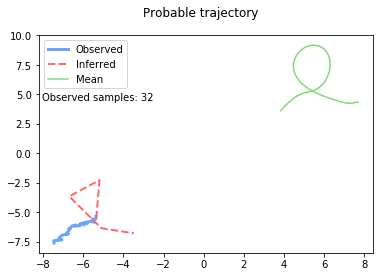

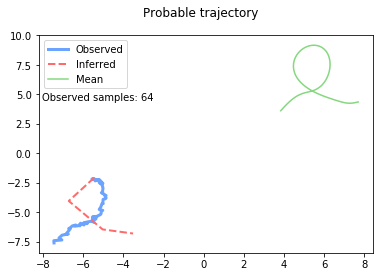

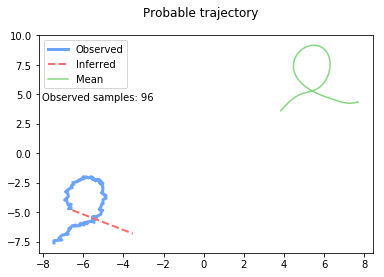

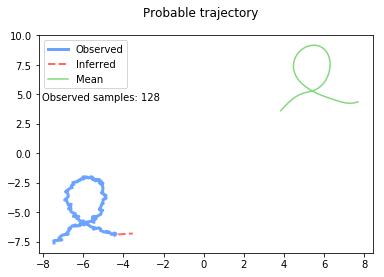

In [22]:
################ Initialize the BIP instance for inference ################

# Set the filter using a deep copy that way we can re-use the filter for inference multiple times without having to re-create it from scratch.
# This is simply for convenience.
primitive.set_filter(copy.deepcopy(filter_enkf))

################ Perform inference and plot the results ################

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory()

prev_observed_index = 0
for observed_index in range(32, test_trajectory_partial.shape[1], 32):
    num_samples = np.max([2, (test_trajectory_partial.shape[1] - observed_index) / 20])
    # Perform inference over the test trajectory in batches of 32 samples, just so we can clearly plot how the inference changes over time.
    # In practice, you can pass as many or as few observations at a time as desired.
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(
        test_trajectory_partial[:, prev_observed_index:observed_index],
        observation_noise,
        active_dofs,
        num_samples = num_samples)
    
    prev_observed_index = observed_index
    
    # Plot the results as we go.
    intprim.util.visualization.plot_partial_trajectory(inferred_trajectory, test_trajectories[0][:, :observed_index], mean_trajectory)

Often, it is useful in real experiments to only predict a single value for the return trajectory.
In interactions where inference is performed at a high frequency, we typically only need to execute the next inferred state and by setting `num_samples = 1` we save on the computation cost (as small as it is) of generating the rest of the trajectory.

### Starting phase

Thus far, we have always inferred a trajectory which starts at the currently estimated phase.
However, in some cases it is useful to estimate a trajectory (or a single state as just mentioned above) at a specific point in time.
This is accomplished with the `starting_phase` parameter of `generate_probable_trajectory_recursive`.
If this parameter is set to `None` (which is the default), then it will use the currently estimated phase as the starting point, but if we set this to a different phase value in the range [0, 1] then it will use this instead.
For example, if we always want to generate a trajectory from the beginning, we can set `starting_phase = 0.0`.

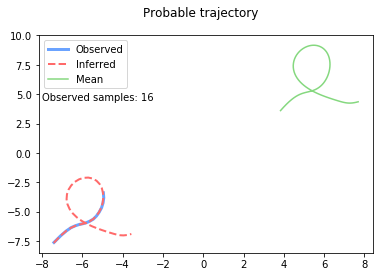

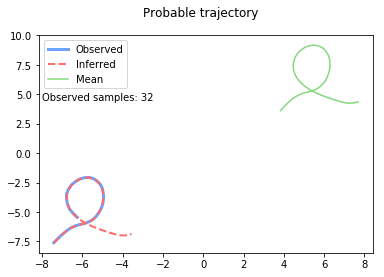

In [23]:
################ Create a test trajectory ################

num_test_trajectories = 1
test_translation_mean = -10.0
test_translation_std = 1e-5
test_noise_std = 0.01
test_length_mean = 45
test_length_std = 1e-5

# Create test trajectories.
test_trajectories = intprim.examples.create_2d_handwriting_data(num_test_trajectories, test_translation_mean, test_translation_std, test_noise_std, test_length_mean, test_length_std)

# Explicitly zero out the x-axis values to illustrate that they are not being used.
test_trajectory_partial = np.array(test_trajectories[0], copy = True)
test_trajectory_partial[0, :] = 0.0

################ Initialize the BIP instance for inference ################

# Set the filter using a deep copy that way we can re-use the filter for inference multiple times without having to re-create it from scratch.
# This is simply for convenience.
primitive.set_filter(copy.deepcopy(filter_enkf))

################ Perform inference and plot the results ################

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory()

prev_observed_index = 0
for observed_index in range(16, test_trajectory_partial.shape[1], 16):
    # Perform inference over the test trajectory in batches of 16 samples, just so we can clearly plot how the inference changes over time.
    # In practice, you can pass as many or as few observations at a time as desired.
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(
        test_trajectory_partial[:, prev_observed_index:observed_index],
        observation_noise,
        active_dofs,
        num_samples = test_trajectory_partial.shape[1],
        starting_phase = 0.0)
    
    prev_observed_index = observed_index
    
    # Plot the results as we go.
    intprim.util.visualization.plot_partial_trajectory(inferred_trajectory, test_trajectories[0][:, :observed_index], mean_trajectory)

Or alternatively, if we want to start inferring from 70% of the way through the interaction, `starting_phase = 0.7`:

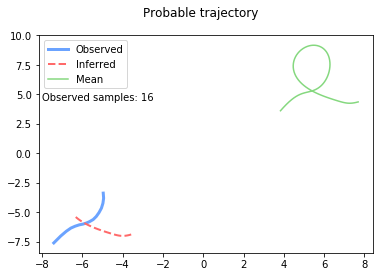

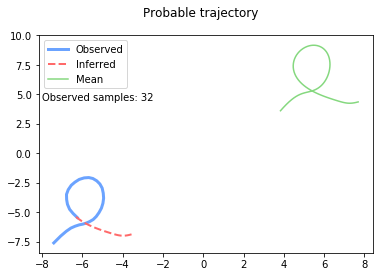

In [24]:
################ Initialize the BIP instance for inference ################

# Set the filter using a deep copy that way we can re-use the filter for inference multiple times without having to re-create it from scratch.
# This is simply for convenience.
primitive.set_filter(copy.deepcopy(filter_enkf))

################ Perform inference and plot the results ################

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory()

prev_observed_index = 0
for observed_index in range(16, test_trajectory_partial.shape[1], 16):
    # Perform inference over the test trajectory in batches of 16 samples, just so we can clearly plot how the inference changes over time.
    # In practice, you can pass as many or as few observations at a time as desired.
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(
        test_trajectory_partial[:, prev_observed_index:observed_index],
        observation_noise,
        active_dofs,
        num_samples = test_trajectory_partial.shape[1],
        starting_phase = 0.7)
    
    prev_observed_index = observed_index
    
    # Plot the results as we go.
    intprim.util.visualization.plot_partial_trajectory(inferred_trajectory, test_trajectories[0][:, :observed_index], mean_trajectory)

### Phase look-ahead

In human-robot interaction, it is very useful to be able to infer about what will happen in the future, which is something that is provided with Bayesian Interaction Primitives and the IntPrim library.
Physical experiments often have to contend with many types of delays due to real world constraints; it takes time to collect observations, perform inference, and execute a control trajectory.
The end effect is that the robot often responds later than we desire, leaving it feeling "sluggish" and non-responsive to the human.
With IntPrim, we provide the ability to return an inferred trajectory beginning at some phase offset into the future, which we denote as a `phase_lookahead`.
In order for this to be utilized, `starting_phase` must be set to `None` and `phase_lookahead` needs to be specified to a value within the range of [0, 1].
For example, if we want to infer our trajectory beginning 10% into the future such that the robot is more responsive, we would perform inference with `phase_lookahead = 0.1`.

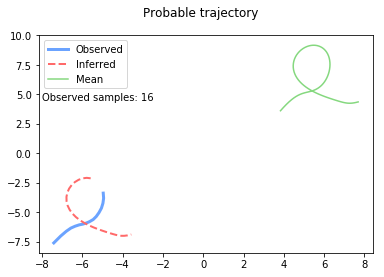

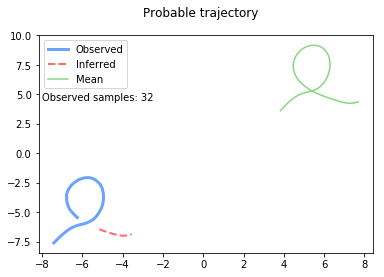

In [25]:
################ Initialize the BIP instance for inference ################

# Set the filter using a deep copy that way we can re-use the filter for inference multiple times without having to re-create it from scratch.
# This is simply for convenience.
primitive.set_filter(copy.deepcopy(filter_enkf))

################ Perform inference and plot the results ################

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory()

prev_observed_index = 0
for observed_index in range(16, test_trajectory_partial.shape[1], 16):
    # Perform inference over the test trajectory in batches of 16 samples, just so we can clearly plot how the inference changes over time.
    # In practice, you can pass as many or as few observations at a time as desired.
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(
        test_trajectory_partial[:, prev_observed_index:observed_index],
        observation_noise,
        active_dofs,
        num_samples = test_trajectory_partial.shape[1] - observed_index,
        phase_lookahead = 0.1)
    
    prev_observed_index = observed_index
    
    # Plot the results as we go.
    intprim.util.visualization.plot_partial_trajectory(inferred_trajectory, test_trajectories[0][:, :observed_index], mean_trajectory)

The caveat is that in more complicated scenarios inference accuracy typically has an inverse relationship with the phase lookahead.
That is, the further into the future that we look the less accurate our predictions are.


## Analysis

IntPrim supports the creation of an analysis file that exports the internal state of the filter to XML format, along with observations and inferred trajectories.
This is useful from an interpretability perspective; if something does not work as intended or we want to see the exact probability distributions at a given point in time we can visualize this with the use of an analysis file and the provided visualization tool.

### Exporting analysis file

In order to export an analysis file, we use the `StatCollector` class.
Upon each call to `generate_probable_trajectory_recursive()`, we will add an additional call to the `collect()` method of `StatCollector` and pass it the relevant information.
Upon completion of the interaction, an analysis file can be created with the `export()` method.

In [26]:
################ Initialize the BIP instance for inference ################

# Set the filter using a deep copy that way we can re-use the filter for inference multiple times without having to re-create it from scratch.
# This is simply for convenience.
primitive.set_filter(copy.deepcopy(filter_enkf))

################ Initialize StatCollector ################

# We need to specify which DoFs we want to infer trajectories for...
generated_indices = np.array([0])
# ...and which we are observing but not inferring. In this example, there is no difference.
observed_indices = np.array([1])

stat_collector = intprim.util.StatCollector(primitive, generated_indices, observed_indices)

################ Perform inference and export the analysis file ################

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory(num_samples = test_trajectory_partial.shape[1])

# Call collect once before inference starts, to capture the initial state of the filter.
# It is important that timestamp = None here and the observed trajectory is empty for visualization to properly function.
# Note that we must transpose the trajectories that are collected.
stat_collector.collect(
    primitive,
    np.array([[] for _ in range(mean_trajectory.shape[0])]),
    mean_trajectory.T,
    timestamp = None)

prev_observed_index = 0
for observed_index in range(1, test_trajectory_partial.shape[1], 1):
    # Perform inference over the test trajectory in batches of 1 samples, just so we can clearly plot how the inference changes over time.
    # In practice, you can pass as many or as few observations at a time as desired.
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(
        test_trajectory_partial[:, prev_observed_index:observed_index],
        observation_noise,
        active_dofs,
        num_samples = test_trajectory_partial.shape[1] - observed_index)
    
    # Pass stat collector the necessary information. Note that the timestamp will be used to sequence calls.
    # In real experimens, this is typically a clock timestamp.
    stat_collector.collect(
        primitive,
        test_trajectories[0][:, prev_observed_index:observed_index].T,
        inferred_trajectory.T,
        timestamp = observed_index)
    
    prev_observed_index = observed_index

# Export the analysis file
stat_collector.export(
    primitive,
    export_dir_path = ".", # The directory in which to save the analysis file
    debug_bag_file = "", # If experiment is conducted from a rosbag file, this can be indicated here. Discussed more in intprim_ros_framework.
    response_length = test_trajectory_partial.shape[1], # The maximum length of the inferrred trajectory
    use_spt = False, # True if num_samples has been set to 1 to only generate a single state
    spt_phase = None # If use_spt is True, the starting_phase.
)

File ./stat_collection_2019-10-09_15-15-50.xml successfully exported.


### Visualization with HTML/JavaScript

IntPrim includes a custom dynamic HTML/JavaScript script which can be run and displayed locally to visualize the information contained in analysis files.
This script is named `index.html` and is located under the `utils` directory in the IntPrim root; simply run it in a web browser (Firefox and Chrome have been tested).
For the script to gain access to the analysis files, a simple Python server must be run to serve the XML files.
Servers for Python 2 and Python 3 have been provided in the `utils` directory.
Copy the appropriate file to the folder which contains the XML analysis files and run it *from that directory*.
Then the visualization script will be able to access the analysis files from a drop down list.

Once an analysis file has been loaded, the script will prominently display three columns of data.
The left column contains plots of the observed DoFs.
Everytime `collect()` is called in the `StatCollector` it creates a *timestep*.
These timesteps can be iterated through by pressing the the arrow buttons at the top of the page, using the arrow keys, or dragging the gray overlay box.
A gray overlay box is displayed over the observed DoF plots to indicate which observations were given in that timestep.
In the above code, observations are integrated one at a time so the corresponding box is very narrow.

The middle column contains plots of the generated DoFs; these correspond to the DoFs that we directly want to control or infer (it is possible to generate all of the DoFs if that is desired).
The orange line indicates what has been actually observed while the blue line indicates the inferred trajectory into the future.
The red lines are previously inferred trajectories and are displayed for reference.

The right column contains information about the internal filter state.
The top 2D plot is a projection of the ensemble to the two most significant principal components.
Intuitively, this is a measure of the uncertainty in the ensemble.
Ideally, this should projection should move around and collapse to a localized region, representing increased confidence in the state estimate.
Below that are the PDFs for the phase system and the generated DoFs.

![Analysis](media/analysis_screen_cap_720.gif)

Lastly, at the very bottom is a visualization of the current covariance matrix.
This is useful for comparing the uncertainty between different DoFs, and it can be expanded to view the covariance of individual basis weights.

![Covariance](media/cov_screen_cap_720.gif)

## References

[1] J. Campbell, S. Stepputtis, and H. Ben Amor. Probabilistic Multimodal Modeling for Human-Robot Interaction Tasks. Robotics: Science and Systems 2019.

[2] J. Campbell and H. Ben Amor. Bayesian Interaction Primitives: A SLAM Approach to Human-Robot Interaction. Conference on Robot Learning 2017.